The dataset was taken from https://www.kaggle.com/datasets/lakshaymiddha/crack-segmentation-dataset

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn

In [2]:
# Parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Resize images
IMG_CHANNELS = 1
# Paths to the dataset
train_image_path = "crack_segmentation_dataset/train/images"
train_mask_path = "crack_segmentation_dataset/train/masks"
test_image_path = "crack_segmentation_dataset/test/images"
test_mask_path = "crack_segmentation_dataset/test/masks"


# Function to load images and masks
def load_data(image_path, mask_path, img_height, img_width, start=0, stop=None):
    if stop is None:
        stop = len(os.listdir(image_path))
    images = []
    masks = []
    count = 0
    for img_name in sorted(os.listdir(image_path))[start:stop]:
        count += 1

        img = cv2.imread(os.path.join(image_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_height, img_width))
        img = img / 255
        images.append(img)

        mask_name = img_name

        mask = cv2.imread(os.path.join(mask_path, mask_name))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (img_height, img_width))
        mask = mask/255
        mask = np.round(mask) # Round mask to 0s and 1s
        masks.append(mask)
        
    print(count)

    return np.array(images), np.array(masks)

We are resizing to 128x128 and converting to grayscale due to memory issues

When training with 3 color channels was tested, the process slowed down significantly (computer ran out of ram and started using swap) with no noticible performance uplift on 2 epochs. The idea of loading higher resolution or 3 channel images from disk with a fancier loader was discarded for speed. 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
train_x, train_y = load_data(train_image_path, train_mask_path, IMG_HEIGHT, IMG_WIDTH, start = 0, stop = None)
train_x = np.array(train_x).astype(np.float32)
train_y = (train_y).astype(np.float32)

9603


In [24]:
test_x, test_y = load_data(test_image_path, test_mask_path, IMG_HEIGHT, IMG_WIDTH, start = 0, stop = None)
test_x = np.array(test_x).astype(np.float32)
test_y = (test_y).astype(np.float32)

1695


In [6]:


class ImageDataset(Dataset):
    def __init__(self, images, masks, augmentations=False):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations

    def __len__(self):
        return len(self.images)

    def transform(self, image, mask):
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.augmentations and random.random() < 0.7:
            
            #random rotation
            random_angle = random.randint(-45, 45) 
            image = TF.rotate(image, random_angle)
            mask = TF.rotate(mask, random_angle)

            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                image, output_size=(IMG_HEIGHT, IMG_WIDTH))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)

            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random vertical flipping
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image).to(device)
        mask = TF.to_tensor(mask).to(device)
        return image, mask

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        
        x, y = self.transform(image, mask)
        return x, y


In [25]:
train_dataset = ImageDataset(train_x, train_y, augmentations = True)
test_dataset = ImageDataset(test_x, test_y)

training_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=True)

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.max_pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_conv = ConvBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.concat_conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, img_channels, initial_depth = 16, height=5):
        super(UNet, self).__init__()
        self.height = height

        # List of encoders
        self.encoders = nn.ModuleList()

        current_channels = initial_depth
        previous_channels = img_channels
        for _ in range(height):
            self.encoders.append(EncoderBlock(previous_channels, current_channels))
            previous_channels = current_channels
            current_channels *= 2

        # Bottleneck
        self.bottleneck = ConvBlock(previous_channels, current_channels)

        # List of decoders
        self.decoders = nn.ModuleList()
        for _ in range(height):
            previous_channels = current_channels
            current_channels //= 2
            self.decoders.append(DecoderBlock(previous_channels, current_channels, current_channels))

        # Final convolution layer
        self.final_conv = nn.Conv2d(initial_depth, n_classes, kernel_size=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        c = []
        for i in range(self.height):
            c_i, x = self.encoders[i](x)
            c.append(c_i)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for i in range(self.height):
            x = self.decoders[i](x, c[-(i + 1)])

        # Final output
        output = self.final_conv(x)
        # output = self.sigmoid(output)
        return output



In [9]:
torch.cuda.empty_cache()
model = UNet(n_classes=1, img_channels=1).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
EPOCHS = 10

def train_one_epoch(model, training_loader, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.
    losses = []

    for i, data in enumerate(training_loader):
        inputs, labels = data

        labels = labels.reshape(-1, IMG_HEIGHT * IMG_WIDTH)

        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.reshape((-1, IMG_HEIGHT * IMG_WIDTH))

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print results
        running_loss += loss.item()
        losses.append(loss.item())
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0


def train_test(epochs, model, training_loader, test_loader, optimizer, loss_fn):
    last_mae = 0
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))

        model.train(True)
        train_one_epoch(model, training_loader, optimizer, loss_fn)

        model.eval()
        mae = []
        with torch.no_grad():
            for i, test_data in enumerate(test_loader):
                test_inputs, test_labels = test_data
                test_labels = test_labels.reshape(-1, IMG_HEIGHT * IMG_WIDTH)

                test_outputs = model(test_inputs)
                test_outputs = test_outputs.reshape((-1, IMG_HEIGHT * IMG_WIDTH))

                # Compute MAE for this batch
                batch_mae = torch.mean(torch.abs(test_labels.to('cpu') - test_outputs.to('cpu')))
                mae.append(batch_mae.item())  # Convert to scalar and append

        # Total MAE
        print('MAE', np.mean(mae))
        last_mae = np.mean(mae)
    return last_mae

train_test(EPOCHS, model, training_loader, test_loader, optimizer, loss_fn)


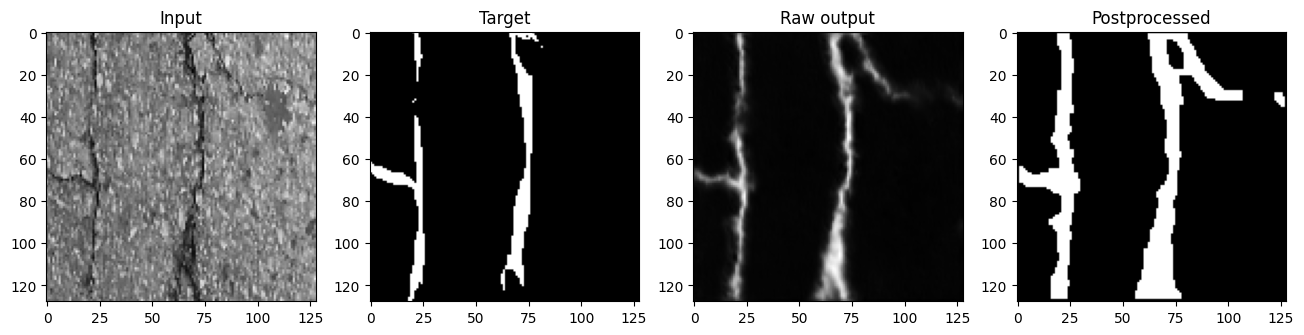

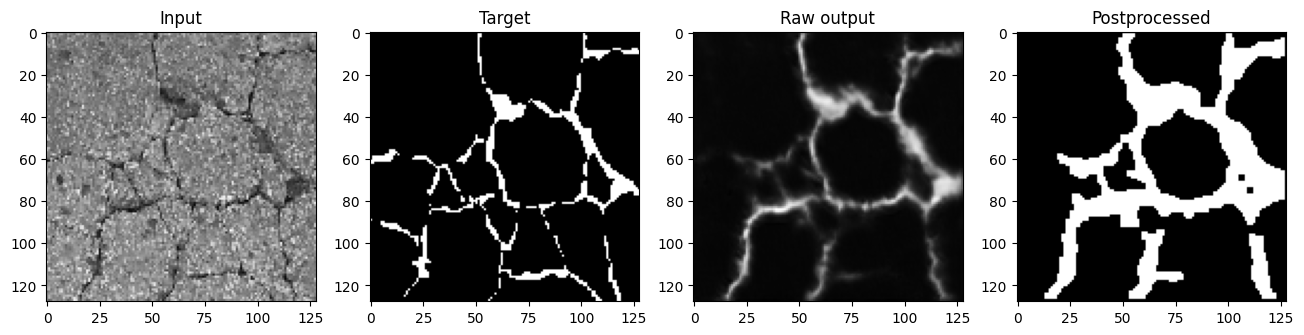

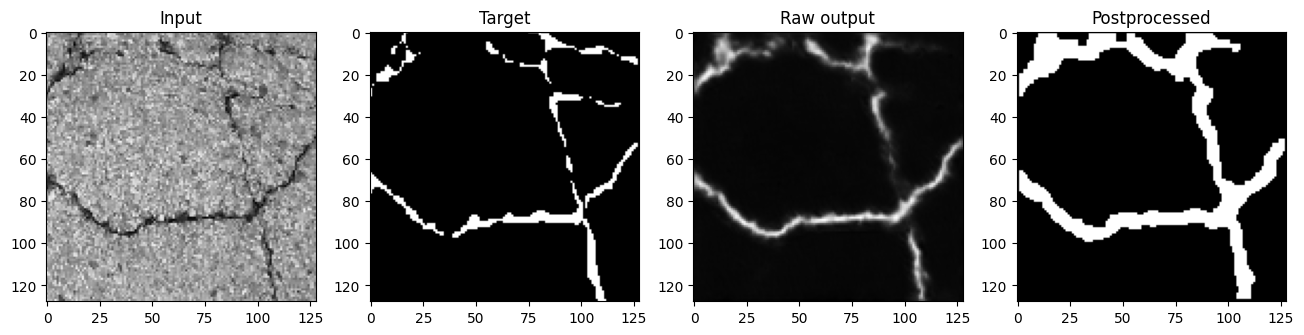

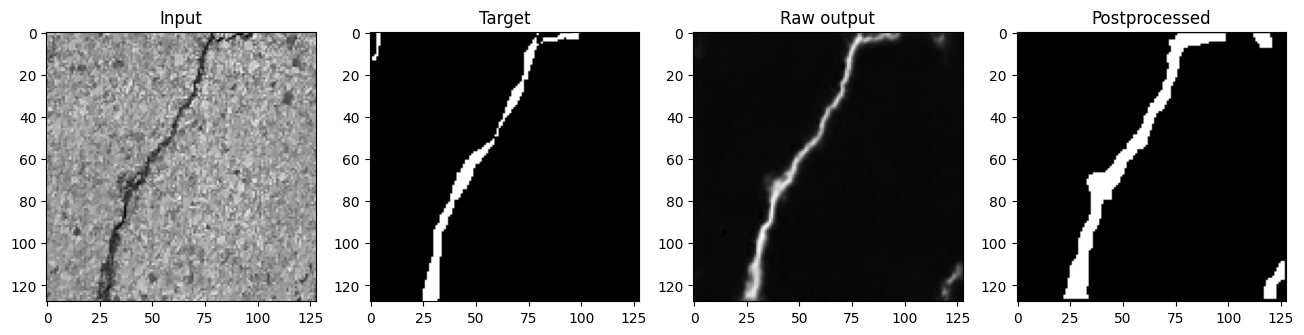

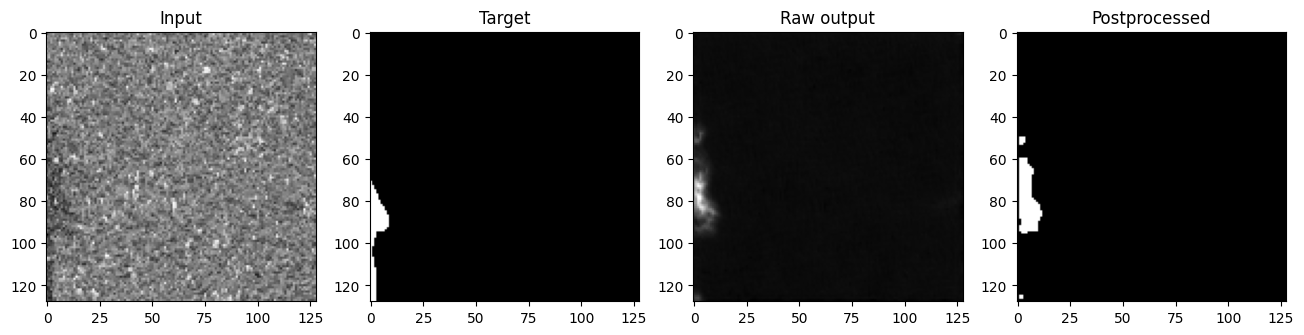

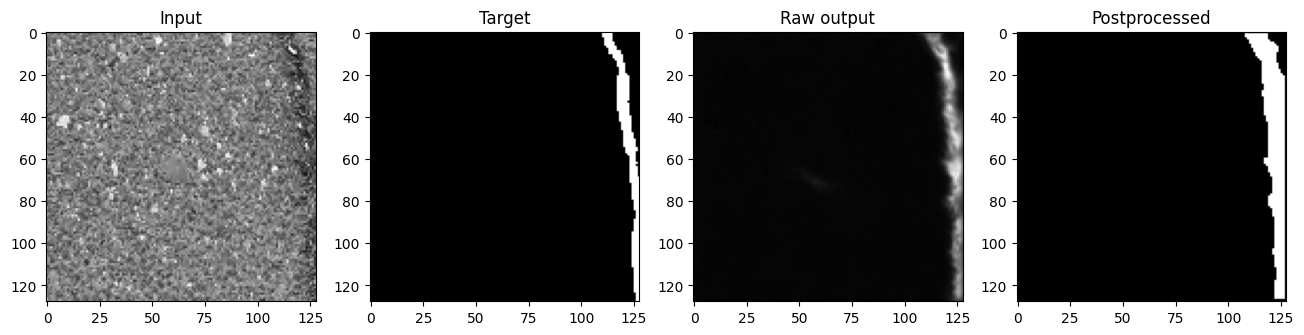

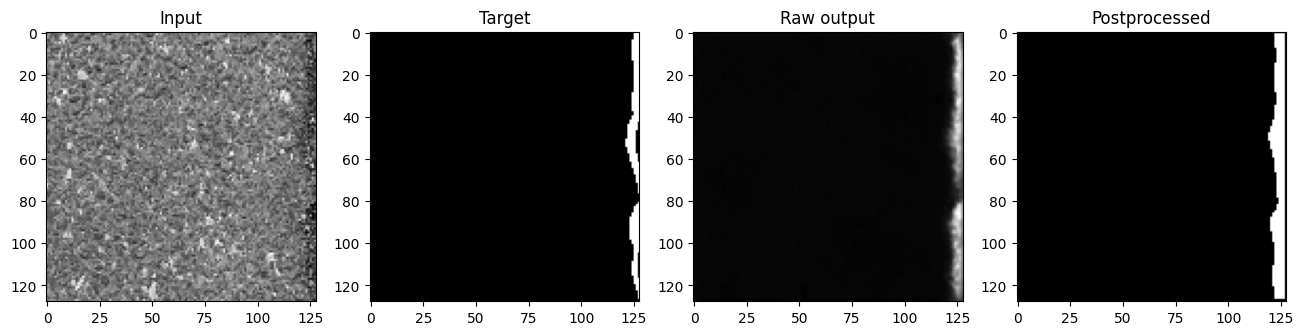

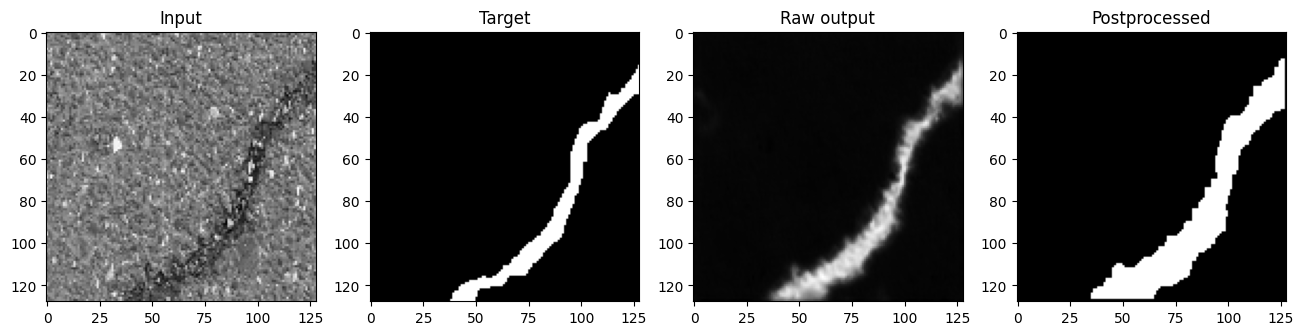

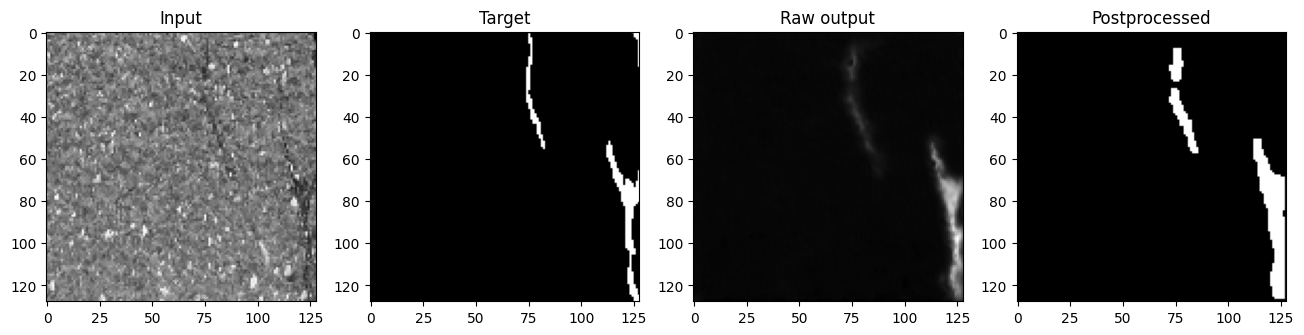

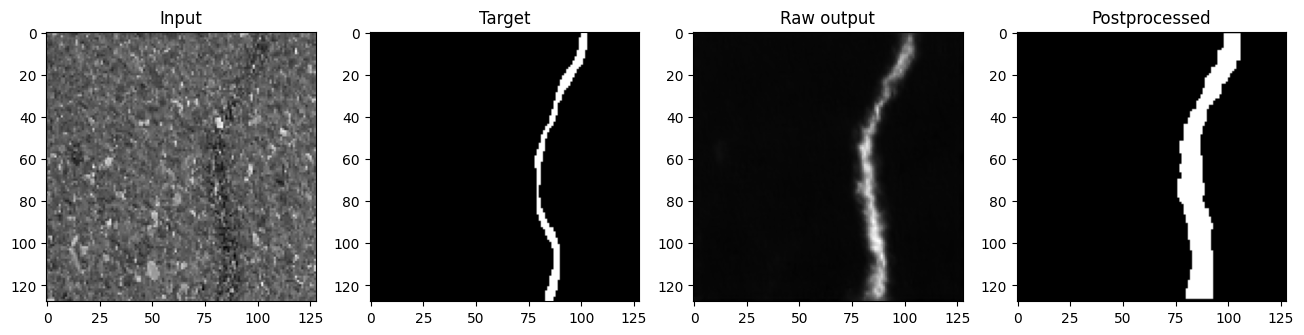

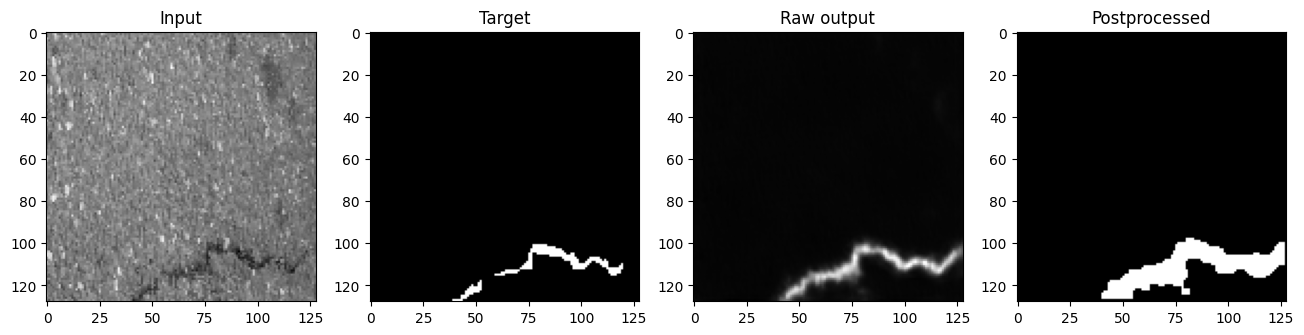

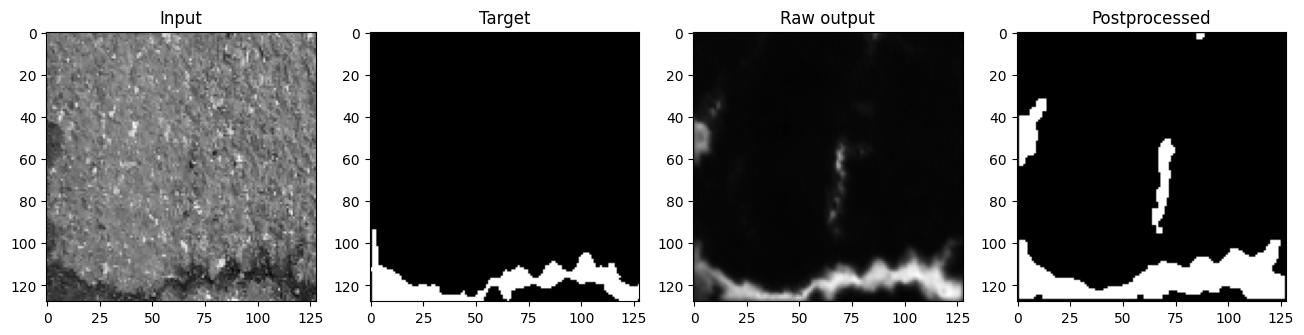

In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation

def morphological_filter(binary_array, structure):
    # Perform opening (erosion followed by dilation)
    opened = binary_dilation(binary_erosion(binary_array, structure=structure), structure=structure)
    
    # Perform closing (dilation followed by erosion)
    closed = binary_erosion(binary_dilation(opened, structure=structure), structure=structure)
    
    return closed




for i in range(48,60):
    img = torch.tensor(test_x[i][np.newaxis, np.newaxis,:]).to(device)
    mask = torch.tensor(test_y[i][np.newaxis, np.newaxis,:]).to(device)
    img_mask = model(img)

    img = img.to('cpu')
    mask = mask.to('cpu')
    img_mask = img_mask.to('cpu')

    input_img = img.reshape((128,128))
    correct_output = mask.reshape((128,128)).numpy()
    output_img = img_mask.reshape((128,128)).detach().numpy()

    processed_img = np.zeros_like(output_img)
    t = 0.05#np.max(output_img)*0.1  # This is a good heuristic for binarization
    processed_img[output_img < t] = 0
    processed_img[output_img >= t] = 1

    structure = np.ones((3, 3), dtype=int)

    # Apply the morphological filter to get rid of artifacts like 1 pixel of activation or small holes in cracks
    processed_img = morphological_filter(processed_img, structure)




    plt.figure(figsize=(16, 16))

    plt.subplot(1, 4, 1)
    plt.title("Input")
    plt.imshow(input_img, cmap='gray')
    plt.subplot(1, 4, 2)
    plt.title("Target")
    plt.imshow(correct_output, cmap='gray')
    plt.subplot(1, 4, 3)
    plt.title("Raw output")
    plt.imshow(output_img, cmap='gray')
    plt.subplot(1, 4, 4)
    plt.title("Postprocessed")
    plt.imshow(processed_img, cmap='gray')

In [12]:
def test_variant(height, depth, training_loader=training_loader, test_loader = test_loader, epochs = 2):
    torch.cuda.empty_cache()
    model = UNet(n_classes=1, img_channels=1, height=height, initial_depth=depth).to(device)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    result = train_test(epochs, model, training_loader, test_loader, optimizer, loss_fn)


    del model  # Delete the model
    torch.cuda.empty_cache()  # Free up unused memory

    return (result, height, depth, epochs)

Adding sigmoid function to the model (currently commented out) was slightly detrimental to its MAE and MSE, in the first epoch, but strongly detrimental to imporvement rate and the visually inspected results were even worse. It is not used in any place in this notebook.

The below cell checks the MAE on the testing set for each combination of depth and height of my U-net.

I defined depth as the 3rd dimension of my U-nets tensor. All tensors in the U-net are proportional to that value.

I defined height as the amount of encoders between input and bottleneck or the amount of decoders between the bottleneck and the output.

The bigger the height and depth the bigger the model

In [16]:
# Create a smaller dataset for speed of testing
train_x, train_y = load_data(train_image_path, train_mask_path, IMG_HEIGHT, IMG_WIDTH, start = 0, stop = 1000)
train_x = np.array(train_x).astype(np.float32)
train_y = (train_y).astype(np.float32)

test_x, test_y = load_data(test_image_path, test_mask_path, IMG_HEIGHT, IMG_WIDTH, start = 0, stop = 100)
test_x = np.array(test_x).astype(np.float32)
test_y = (test_y).astype(np.float32)

train_dataset = ImageDataset(train_x, train_y, augmentations = True)
test_dataset = ImageDataset(test_x, test_y)

training_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=True)

1000
100


In [ ]:
heights = [2, 3, 5]
depths = [4, 8, 16]
results = []

for height in heights:
    for depth in depths:
        result = test_variant(height=height, depth=depth, epochs=3)
        results.append(result)


These results are not a good representations of the capabilities of these architectures, as this score after 3 epochs randomly varies vastly from one run to another. However this demonstrates the flexibility of a U-net model with easily settible height and depth and its usefulnes in testing

In [18]:
results.sort()
for result in results:
    print(result)

(0.039866891390872454, 3, 16, 3)
(0.048501108614903574, 5, 16, 3)
(0.0501593586830598, 2, 16, 3)
(0.05160269682418625, 2, 8, 3)
(0.05496534431036913, 3, 8, 3)
(0.05670957569524927, 5, 8, 3)
(0.07053729933950137, 3, 4, 3)
(0.0789230522119774, 5, 4, 3)
(0.07912587205756386, 2, 4, 3)
